# GAN on MNIST

In [85]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import cv2

In [86]:
from IPython.display import clear_output

In [87]:
TEXTILE_PATH = '/Users/maximperehod/Desktop/archive/image/Apple'

In [88]:
CUDA = False
DATA_PATH = './data'
BATCH_SIZE = 1
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 32
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [89]:
transform = transforms.Compose([
    transforms.CenterCrop(X_DIM),
    transforms.ToTensor(),
])

In [90]:
class ImageFolderDataset(Dataset):
    def __init__(self, data_folder, image_size):
        self.data_folder = data_folder
        self.image_size = image_size
        self.image_transforms = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size), 
            transforms.ToTensor(),
            
        ])
        self.image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.png')]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image_file = self.image_files[0]
        image = Image.open(image_file)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = self.image_transforms(image)
        return image

In [91]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.12.1


In [92]:
# Data preprocessing
dataset = ImageFolderDataset(TEXTILE_PATH, X_DIM)

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

### Some images from batch

torch.Size([1, 3, 32, 32])


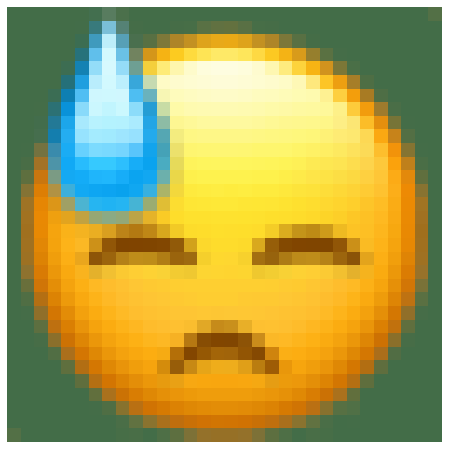

In [93]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
print(real_batch.shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(), (1,2,0)))

In [94]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator and Discriminator

In [113]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 16, 4, 1, 0, bias=False), # 4
            nn.BatchNorm2d(G_HIDDEN * 16),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 16, G_HIDDEN * 8, 4, 2, 1, bias=False), # 8
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(8*G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [114]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 3rd layer
            nn.Conv2d(3, D_HIDDEN * 4, 4, 2, 1, bias=False), # 16
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False), # 8
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 8, D_HIDDEN * 16, 4, 2, 1, bias=False), # 4
            nn.BatchNorm2d(D_HIDDEN * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 16, 1, 4, 1, 0, bias=False), # 2
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [115]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

In [116]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [117]:
EPOCH_NUM = 50

In [118]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(1000):
    for i, data in enumerate(dataloader, 0):
        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        iters += 1
        
               
        with torch.no_grad():
            fake = netG(viz_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        clear_output(True)
        plt.figure(figsize=(5,5))

        # Plot the fake images from the last epoch
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.savefig('wow6.png')
        plt.show()

Starting Training Loop...


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

In [ ]:
plt.plot(G_losses, label='generator')
plt.plot(D_losses, label='discriminator')
plt.legend()

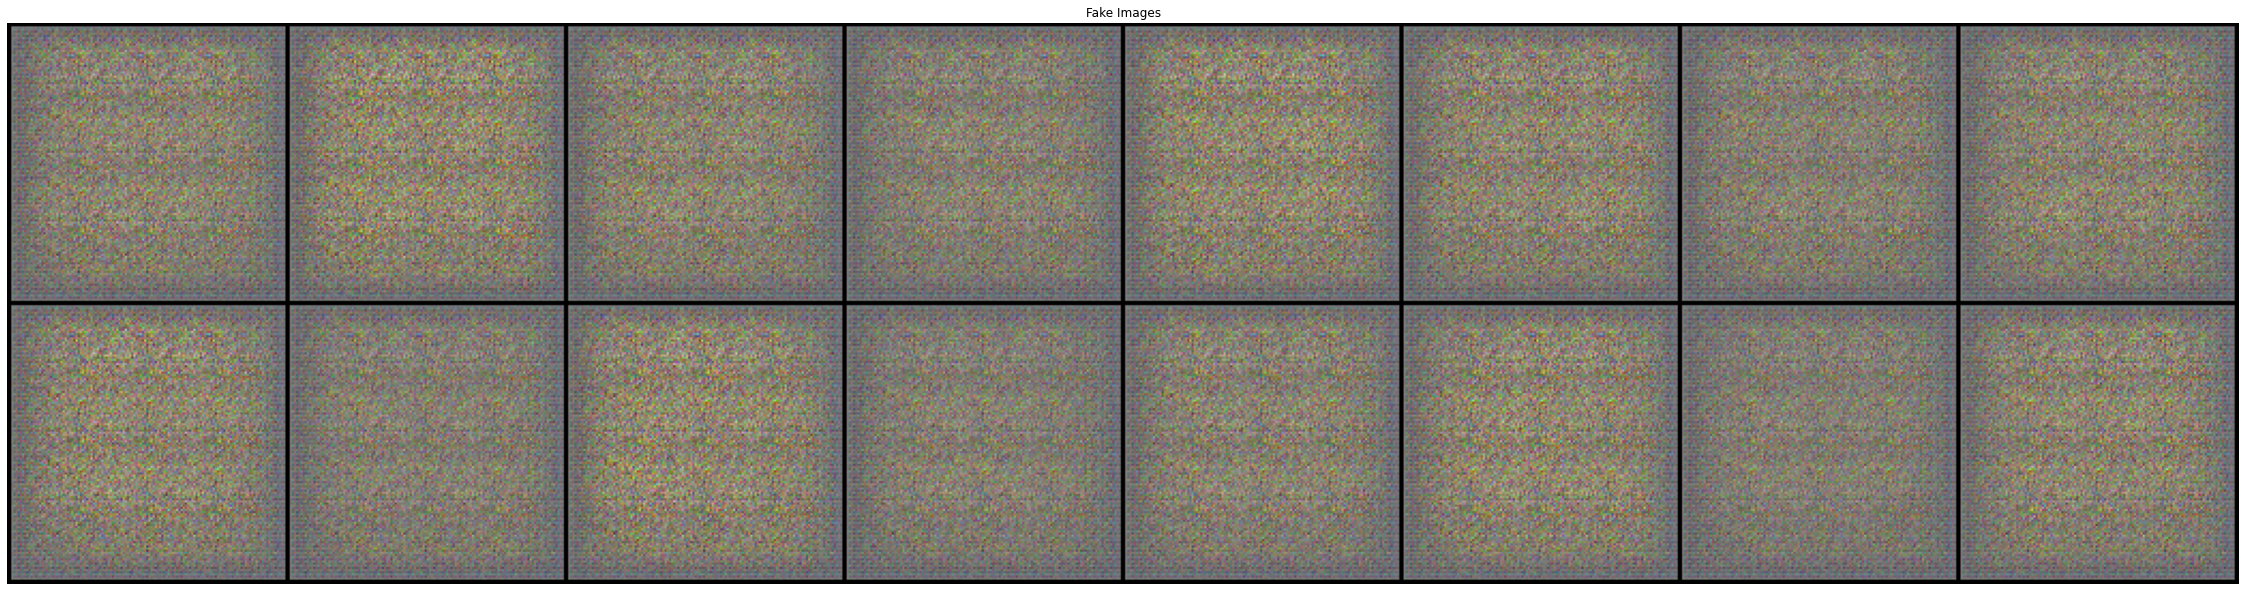

In [48]:
# Plot the real images
plt.figure(figsize=(40,40))

# Plot the fake images from the last epoch
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('wow6.png')
plt.show()

In [ ]:
torch.save(netG, './models/batch_8/pattern_GAN_G_52_epoch.pth')
torch.save(netD, './models/batch_8/pattern_GAN_D_52_epoch.pth')

In [ ]:
netG = torch.load('./models/batch_8/pattern_GAN_G_90_epoch.pth')
netG.eval()

netD = torch.load('./models/batch_8/pattern_GAN_D_80_epoch.pth')
netD.eval()

In [ ]:
noise = torch.randn(32, Z_DIM, 1, 1, device=device)
fake = []
plt.figure(figsize=(40,40))
with torch.no_grad():
    fake = netG(noise).detach().cpu()
    
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()
plt.savefig('test.png')